In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import sklearn.metrics as met
import xgboost as xgb

In [16]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [14]:
stock_li = list(raw_data.keys())

In [176]:
import pickle
with open('raw_data_20190115.pickle', 'rb') as handle:
    raw_data = pickle.load(handle)

In [177]:
for i,j in raw_data.items():
    raw_data[i] = j.loc['2006-01-01':]

In [ ]:
use_stock = ['KB금융', 'LG', 'LG생활건강', 'LG화학', 'NAVER', 'SK', 'SK이노베이션', 'SK텔레콤', 'SK하이닉스', '삼성생명', '삼성전자', '삼성중공업', '셀트리온', '신한지주', '현대건설', '현대글로비스']
del_li = [i for i in raw_data.keys() if i not in use_stock]
for stock in use_stock:
    if 

In [178]:
del_li = []
for i in raw_data.keys():
    if i not in stock_li:
        del_li.append(i)
for i in del_li:
    del raw_data[i]

In [179]:
raw_data.keys()

dict_keys(['KB금융', 'LG', 'LG생활건강', 'LG화학', 'NAVER', 'SK', 'SK이노베이션', 'SK텔레콤', 'SK하이닉스', '삼성생명', '삼성전자', '삼성중공업', '셀트리온', '신한지주', '현대건설', '현대글로비스'])

In [180]:
def get_MACD(df, short_ma=12, long_ma=26, signal_period=9):
    ewm_12 = df['Close'].ewm(span = short_ma, min_periods = short_ma - 1).mean()
    ewm_26 = df['Close'].ewm(span = long_ma, min_periods = long_ma - 1).mean()
    df['MACD'] = ewm_12 - ewm_26
    df['MACDSignal'] = df['MACD'].ewm(span = signal_period, min_periods = signal_period-1).mean()
    df['MACDDiff'] = df['MACD'] - df['MACDSignal']
    return df

def get_Stochastic(df, n=14):
    df['sto_K_{}'.format(n)] = 100 * ((df.Close - df.Low.rolling(n).min()) / 
                                      (df.High.rolling(n).max() - df.Low.rolling(n).min()))
    df['sto_D_{}'.format(n)] = df['sto_K_{}'.format(n)].rolling(3).mean()
    return df
    
def get_RSI(df, n=14):
    U = np.where(df['Close'].diff(1)>0, df['Close'].diff(1), 0)
    D = np.where(df['Close'].diff(1)<0, df['Close'].diff(1)*(-1), 0)
    
    AU = pd.Series(U).rolling(window=n, min_periods=n).mean()
    AD = pd.Series(D).rolling(window=n, min_periods=n).mean()
    
    RSI = AU.div(AD+AU) * 100
    df['RSI_{}'.format(n)] = RSI.values
    return df
    
def get_BolingerBand(df, n=20, k=2):
    df = df.assign(BolingerCenter = df['Close'].rolling(window=n).mean())
    df = df.assign(Bol_upper = df['Close'].rolling(window=n).mean() + k*df['Close'].rolling(window=n).std())
    df = df.assign(Bol_lower = df['Close'].rolling(window=n).mean() - k*df['Close'].rolling(window=n).std())
    return df

def get_SMA(df, window):
    df['close_ma_{}'.format(window)] = df['Close'].rolling(window).mean()
    return df
    
def get_EMA(df, window):
    df['close_ema_{}'.format(window)] = df['Close'].ewm(span=window).mean()
    return df
    
def get_RoC(df, periods):
    df['roc_{}'.format(periods)] = df['Close'].pct_change(periods=periods)
    return df
    
def get_CV(df, window):
    df['his_vol_{}'.format(window)] = np.log(df['Close'] / df['Close'].shift(1)).rolling(window).std()*(252**0.5)
    return df
    
def get_WilliamR(df, n):
    W_R = -100 * ((df.High.rolling(n).max() - df.Close) / (df.High.rolling(n).max() - df.Low.rolling(n).min()))
    df['WR_{}'.format(n)] = W_R
    return df
    
def get_CCI(df, window):
    TP = (df.Close + df.Low + df.High) / 3
    dataX = []
    for i in range(len(TP) - window+1):
        a = TP.values[i:(i+window)]
        dataX.append(a)
    dataMean = [i.mean() for i in dataX]
    AVEDEV = [abs(x - mean).mean() for x, mean 
              in zip(dataX, dataMean)]
    for i in range(window-1):
        AVEDEV.insert(0,np.nan)
    AVEDEV = pd.Series(AVEDEV, index = TP.index)
    CCI = (TP - TP.rolling(20).mean()) / (0.015 * AVEDEV)
    df['CCI_{}'.format(window)] = CCI
    return df
    
def get_DI(df, window):
    df['DI_{}'.format(window)] = 100 * ((df.Close - df.Close.rolling(window).mean()) / df.Close.rolling(window).mean())
    return df

def get_VPT(df):
    df['VPT'] = ((test.Close.diff(1) / test.Close) * test.Volume).cumsum()
    return df
    
def get_MA_diff(df, window):
    df['ma_diff_{}'.format(window)] = df['Close'].rolling(window).mean() - df['Close'].shift(window).rolling(window).mean()
    return df

def get_MA_n_diff(df, n, window):
    df['ma_{}_diff_{}'.format(n, window)] = df['Close'].rolling(window).mean() - df['Close'].rolling(window+n).mean()
    return df
    
def get_OBV(df):
    df['OBV'] = (np.sign(df['Close'].diff(1).fillna(0)) * df['Volume']).cumsum()
    return df

In [181]:
import time
for key, df in raw_data.items():
    start = time.time()
    print(key)
    for window in range(1, 91):
        raw_data[key] = get_SMA(df, window)
        raw_data[key] = get_EMA(df, window)
    n = 10
    for window in range(1, 91):
        raw_data[key] = get_MA_diff(df, window)
        raw_data[key] = get_MA_n_diff(df, n, window)
    for window in range(12, 91):
        raw_data[key] = get_CV(df, window)
    for periods in range(1, 11):
        raw_data[key] = get_RoC(df, periods)
    for n in range(3, 91):
        raw_data[key] = get_RSI(df, n)
        raw_data[key] = get_Stochastic(df, n)
        raw_data[key] = get_WilliamR(df, n)
    raw_data[key] = get_CCI(df, 20)
    for window in [5,10]:
        raw_data[key] = get_DI(df, window)
    raw_data[key] = get_MACD(df)
    raw_data[key] = get_OBV(df)
    print('Done {:.2f} sec'.format(time.time() - start))

KB금융
Done 2.41 sec
LG
Done 2.18 sec
LG생활건강
Done 2.17 sec
LG화학
Done 2.09 sec
NAVER
Done 2.07 sec
SK
Done 1.97 sec
SK이노베이션
Done 2.04 sec
SK텔레콤
Done 2.08 sec
SK하이닉스
Done 2.11 sec
삼성생명
Done 1.99 sec
삼성전자
Done 2.09 sec
삼성중공업
Done 2.09 sec
셀트리온
Done 2.07 sec
신한지주
Done 2.24 sec
현대건설
Done 2.51 sec
현대글로비스
Done 3.12 sec


In [182]:
for key, df in raw_data.items():
    print(key)
    for i in range(1, 33, 3):
        df['Y1_{:02}'.format(i)] = np.log(df['Close'].shift(-1*i) / df['Close'])
        for j in range(1, 90, 3):
            df['sh{:02}_Y2_{:02}'.format(i, j)] = np.log(df['Close'].shift(-1*i) / df['Close'].rolling(j).mean())

KB금융
LG
LG생활건강
LG화학
NAVER
SK
SK이노베이션
SK텔레콤
SK하이닉스
삼성생명
삼성전자
삼성중공업
셀트리온
신한지주
현대건설
현대글로비스


In [183]:
y_li = [i
    for i in [col for col in raw_data['삼성전자'] 
              if (col.find('Y') != -1)]
]

In [94]:
len(y_li)

341

In [95]:
import time

prepare_training = {}
for key, df in raw_data.items():
    print(key)
    start = time.time()
    target_set = {}
    for y in y_li:
        col_set = {}
        for col_name in ['sto_K','sto_D','RSI','close_ma','close_ema','roc','his_vol','WR',
                         'CCI','DI','ma_diff','MACD','MACDSignal','MACDDiff','OBV']:
            corr_ = abs(df[[col for col in df if (col.find(col_name) != -1)|
                    (col.find(y) != -1)]].corr()[y]).sort_values(ascending=False)
            col_set[corr_.index[1]] = corr_.iloc[1]
        target_set[y] = col_set
    prepare_training[key] = target_set
    elapse = time.time() - start
    print('{:.2f} sec'.format(elapse))

KB금융
152.03 sec
LG
171.81 sec
LG생활건강
172.15 sec
LG화학
176.38 sec
NAVER
169.56 sec
SK
123.07 sec
SK이노베이션
147.32 sec
SK텔레콤
174.77 sec
SK하이닉스
166.59 sec
삼성생명
113.90 sec
삼성전자
165.49 sec
삼성중공업
171.26 sec
셀트리온
162.86 sec
신한지주
177.59 sec
현대건설
167.30 sec
현대글로비스
190.05 sec


In [97]:
prepare_training

{'KB금융': {'Y1_01': {'sto_K_51': 0.04418005842714482,
   'sto_D_3': 0.059632424662898545,
   'RSI_51': 0.05795023115758831,
   'close_ma_2': 0.06878969152319785,
   'close_ema_1': 0.06349355860881731,
   'roc_5': 0.06959747235344375,
   'his_vol_50': 0.055936886645993424,
   'WR_51': 0.04418005842714484,
   'CCI_20': 0.012473133312258008,
   'DI_10': 0.062141474619557976,
   'ma_diff_26': 0.06854101967769485,
   'MACDDiff': 0.04652547918446377,
   'MACDSignal': 0.0068887326290285366,
   'OBV': 0.016327907877143808},
  'sh01_Y2_01': {'sto_K_51': 0.044180058427144744,
   'sto_D_3': 0.059632424662898385,
   'RSI_51': 0.05795023115758806,
   'close_ma_2': 0.06878969152319696,
   'close_ema_1': 0.06349355860881624,
   'roc_5': 0.069597472353444,
   'his_vol_50': 0.05593688664599046,
   'WR_51': 0.04418005842714475,
   'CCI_20': 0.012473133312258019,
   'DI_10': 0.06214147461955798,
   'ma_diff_26': 0.06854101967769434,
   'MACDDiff': 0.046525479184464195,
   'MACDSignal': 0.00688873262902807

In [98]:
store = (raw_data, prepare_training)
with open('raw_and_prepare_columns_20190416.pickle', 'wb') as handle:
    pickle.dump(store, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [186]:
for i,j in raw_data.items():
    raw_data[i] = j.dropna()

In [187]:
for i,j in raw_data.items():
    raw_data[i] = j.loc['2007-01-01':]

In [118]:
Train, Test = {}, {}
for i, df in raw_data.items():
    d1, d2 = {}, {}
    for y in y_li:
        li = list(prepare_training[i][y].keys())
        li.append(y)
        d1[y] = df[li].loc[:'2017-06-30']
        d2[y] = df[li].loc['2017-06-30':]
    Train[i] = d1
    Test[i] = d2

In [119]:
Train['삼성전자']['sh04_Y2_07']

sto_K_6    sto_D_5      RSI_5   close_ma_56  close_ema_1  \
Date                                                                      
2007-01-02   96.000000  74.592593  64.516129  12567.500000      12520.0   
2007-01-03   46.153846  67.754986  54.054054  12558.571429      12280.0   
2007-01-04   15.384615  51.384615  48.780488  12545.000000      12120.0   
2007-01-05    0.000000  19.384615  28.888889  12525.357143      11900.0   
2007-01-08   10.204082   7.401361  23.636364  12502.857143      11680.0   
2007-01-09   14.285714   8.163265   4.545455  12482.857143      11720.0   
2007-01-10    5.660377  10.865968   5.000000  12462.142857      11560.0   
2007-01-11   21.621622  15.307745  18.918919  12444.642857      11660.0   
2007-01-12   91.176471  43.879173  61.224490  12437.857143      12120.0   
2007-01-15   92.500000  72.009804  81.818182  12432.500000      12240.0   
2007-01-16   95.000000  95.833333  81.395349  12428.214286      12260.0   
2007-01-17   67.500000  84.121622  76.086957  12418.571429      12040.0   
2007-01-18   43.243243  63.288288  61.224490  12409.285714      11880.0   
2007-01-19   16.666667  37.177177  20.000000  12400.714286      11700.0   
2007-01-22   33.333333  26.666667  20.000000  12393.571429      11820.0   
2007-01-23   41.666667  32.795699  24.324324  12386.071429      11880.0   
2007-01-24   74.193548  57.906810  50.000000  12381.785714      12040.0   
2007-01-25   82.758621  74.381906  66.666667  12378.928571      12060.0   
2007-01-26   31.034483  64.919540  54.545455  12372.857143      11760.0   
2007-01-29    3.225806  35.328142  32.432432  12361.785714      11560.0   
2007-01-30   30.303030  17.842946  39.024390  12351.071429      11700.0   
2007-01-31   15.151515  16.226784  21.052632  12332.857143      11600.0   
2007-02-01   12.121212  20.484848  18.421053  12315.000000      11580.0   
2007-02-02   52.000000  37.467172  50.000000  12296.428571      11760.0   
2007-02-05   68.750000  55.333333  66.666667  12274.642857      11720.0   
2007-02-06   75.000000  75.000000  55.555556  12247.857143      11740.0   
2007-02-07   68.750000  70.138889  71.428571  12222.500000      11720.0   
2007-02-08   46.666667  56.313131  62.500000  12196.071429      11660.0   
2007-02-09   33.333333  43.434343  14.285714  12171.428571      11660.0   
2007-02-12   14.285714  25.974026   6.250000  12143.571429      11440.0   
...                ...        ...        ...           ...          ...   
2017-05-19    0.000000  34.210703  25.225225  42203.571429      44720.0   
2017-05-22   18.269231  16.671754  28.448276  42326.428571      45100.0   
2017-05-23    9.615385   9.561966  17.117117  42448.928571      44920.0   
2017-05-24    8.333333  13.728632  17.117117  42563.928571      44880.0   
2017-05-25   75.000000  37.827568  45.038168  42670.357143      45680.0   
2017-05-26   78.160920  60.237699  87.777778  42785.714286      46080.0   
2017-05-29   50.588235  72.536896  63.829787  42884.642857      45620.0   
2017-05-30    8.080808  45.041819  44.776119  42963.928571      44640.0   
2017-05-31   14.563107  24.013835  46.666667  43044.285714      44700.0   
2017-06-01   13.592233  12.078716  23.958333  43124.285714      44680.0   
2017-06-02   75.728155  35.385113  47.857143  43227.500000      45960.0   
2017-06-05   77.000000  56.721221  56.779661  43322.857143      45940.0   
2017-06-07   42.857143  66.476190  66.336634  43393.214286      45300.0   
2017-06-08   36.190476  52.539683  60.952381  43460.357143      45160.0   
2017-06-09   80.952381  50.793651  73.509934  43536.428571      46100.0   
2017-06-12   25.333333  44.952381  38.211382  43589.642857      45380.0   
2017-06-13   26.666667  41.777778  39.024390  43652.142857      45400.0   
2017-06-14   24.000000  25.666667  51.612903  43702.142857      45360.0   
2017-06-15   47.222222  31.068376  62.745098  43759.642857      45680.0   
2017-06-16   33.846154  38.121516  28.333333  43827.142857      45580.0   
2017-06-19  100.000000  63.121516  90.41

In [120]:
Test['삼성전자']['sh04_Y2_07']

sto_K_6    sto_D_5       RSI_5   close_ma_56  close_ema_1  \
Date                                                                       
2017-06-30   33.846154  38.492936   47.916667  44914.285714      47540.0   
2017-07-03    9.230769  32.046049   16.455696  45014.642857      47220.0   
2017-07-04    6.666667  16.706392   13.483146  45105.000000      47000.0   
2017-07-05   51.948052  22.740358   46.590909  45211.785714      47580.0   
2017-07-06   83.116883  51.986667   53.000000  45321.785714      48060.0   
2017-07-07   80.597015  76.504921   58.888889  45418.928571      47860.0   
2017-07-10   88.679245  88.748652   81.578947  45537.500000      48660.0   
2017-07-11  100.000000  89.758753   91.666667  45670.357143      49000.0   
2017-07-12   96.273292  94.545743   92.592593  45820.000000      49880.0   
2017-07-13   88.554217  94.504067   93.103448  45992.500000      50560.0   
2017-07-14   82.658960  87.361210   97.122302  46174.642857      50480.0   
2017-07-17   84.285714  83.803787   96.261682  46351.071429      50640.0   
2017-07-18   91.428571  84.047619   96.000000  46522.500000      50840.0   
2017-07-19   84.821429  80.696649   85.245902  46666.071429      50740.0   
2017-07-20   90.909091  82.904441   82.000000  46816.071429      51200.0   
2017-07-21   81.818182  80.415264   78.846154  46945.357143      51080.0   
2017-07-24   65.151515  79.292929   60.000000  47056.785714      50860.0   
2017-07-25    4.347826  50.439174   26.136364  47147.857143      50000.0   
2017-07-26   26.732673  32.077338   25.274725  47225.000000      49840.0   
2017-07-27   24.752475  19.320740    0.000000  47274.642857      49800.0   
2017-07-28   10.052910  21.370544    0.000000  47313.214286      47760.0   
2017-07-31   31.372549  23.570764   12.429379  47361.428571      48200.0   
2017-08-01   43.750000  29.663954   27.272727  47411.071429      48600.0   
2017-08-02   55.913978  44.802867   37.349398  47462.857143      49000.0   
2017-08-03   23.118280  43.645460   27.555556  47487.857143      47780.0   
2017-08-04   27.083333  39.335498   48.818898  47512.142857      47700.0   
2017-08-07   27.272727  27.604412   36.036036  47541.428571      47580.0   
2017-08-08   27.027027  26.659718   27.551020  47595.000000      47720.0   
2017-08-09    1.290323  16.399008    4.666667  47616.071429      46280.0   
2017-08-10   12.429379  14.730196    6.481481  47633.571429      45900.0   
...                ...        ...         ...           ...          ...   
2018-07-03   21.666667  17.393162   39.240506  49934.285714      46150.0   
2018-07-04   25.000000  22.929293   22.580645  49887.321429      46250.0   
2018-07-05   27.272727  31.464646   31.111111  49835.357143      45950.0   
2018-07-06   10.000000  27.575758   22.222222  49762.142857      44900.0   
2018-07-09   38.000000  25.618687   50.909091  49687.142857      45600.0   
2018-07-10   68.750000  39.444444   52.631579  49615.000000      46300.0   
2018-07-11   56.250000  59.795322   45.901639  49543.928571      46000.0   
2018-07-12   44.736842  61.513158   43.076923  49439.285714      45500.0   
2018-07-13   97.368421  70.695257   75.000000  49327.142857      46500.0   
2018-07-16   53.125000  62.487237   57.627119  49227.678571      46050.0   
2018-07-17   32.142857  58.289242   40.816327  49119.642857      45850.0   
2018-07-18   63.888889  47.142857   59.649123  49049.821429      46550.0   
2018-07-19   82.857143  58.750000   75.925926  48987.321429      46900.0   
2018-07-20   92.500000  78.869048   71.111111  48903.571429      47450.0   
2018-07-23   45.000000  72.916667   58.181818  48787.500000      46500.0   
2018-07-24   27.500000  49.873737   55.172414  48665.178571      46150.0   
2018-07-25   14.705882  23.942365   40.909091  48542.857143      46150.0   
2018-07-26   58.823529  28.550208   50.000000  48433.928571      46900.0   
2018-07-27   58.823529  50.150830   36.585366  48344.642857      46900.0   
2018-07-30   46.153846  63.430687   50.000000  48235.714286    

In [124]:
a = Test['삼성전자']['sh04_Y2_07'][:int(.8 * len(Test['삼성전자']['sh04_Y2_07']))]

In [133]:
y = 'sh04_Y2_07'
[i for i in a.columns if y != i]

['sto_K_6',
 'sto_D_5',
 'RSI_5',
 'close_ma_56',
 'close_ema_1',
 'roc_4',
 'his_vol_76',
 'WR_6',
 'CCI_20',
 'DI_5',
 'ma_diff_3',
 'MACDDiff',
 'MACDSignal',
 'OBV']

In [191]:
Y1col = [col for col in raw_data['삼성전자'].columns if col.find('Y1') != -1]

In [192]:
Y1_set = {}
for i,j in raw_data.items():
    Y1_set[i] = j[Y1col]

In [194]:
with open('Y1_set_20190416.pickle', 'wb') as handle:
    pickle.dump(Y1_set, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [134]:
with open('0306_dataset.pickle', 'rb') as handle:
    raw_data,prepare_training = pickle.load(handle)
    
with open('0326_predData.pickle', 'rb') as handle:
    stock_score,stock_pred,max_precision = pickle.load(handle)

In [154]:
Train['삼성전자']['Y1_01']

sto_K_11    sto_D_3       RSI_4  close_ma_2  close_ema_1  \
Date                                                                     
2007-01-02   96.296296  86.786019   80.000000     12390.0      12520.0   
2007-01-03   46.153846  60.860093   60.606061     12400.0      12280.0   
2007-01-04   15.384615  43.291465   38.235294     12200.0      12120.0   
2007-01-05    0.000000  11.407407   29.545455     12010.0      11900.0   
2007-01-08   10.204082   9.050505    0.000000     11790.0      11680.0   
2007-01-09   14.285714  12.828283    6.250000     11700.0      11720.0   
2007-01-10    5.660377  18.091441    6.250000     11640.0      11560.0   
2007-01-11   15.094340  27.076023   26.923077     11610.0      11660.0   
2007-01-12   58.490566  52.631579   78.947368     11890.0      12120.0   
2007-01-15   69.811321  77.999052   80.952381     12180.0      12240.0   
2007-01-16   71.698113  95.075075  100.000000     12250.0      12260.0   
2007-01-17   50.943396  71.001001   73.170732     12150.0      12040.0   
2007-01-18   47.500000  46.780627   26.923077     11960.0      11880.0   
2007-01-19   25.000000  22.121129    3.448276     11790.0      11700.0   
2007-01-22   40.000000  32.861869   17.647059     11760.0      11820.0   
2007-01-23   47.500000  50.261137   34.615385     11850.0      11880.0   
2007-01-24   67.500000  73.968254   65.384615     11960.0      12040.0   
2007-01-25   67.567568  78.968254  100.000000     12050.0      12060.0   
2007-01-26   25.000000  56.746032   44.444444     11910.0      11760.0   
2007-01-29    2.631579  27.662570   26.470588     11660.0      11560.0   
2007-01-30   25.000000  15.995904   24.242424     11630.0      11700.0   
2007-01-31   14.285714  24.825269   18.918919     11650.0      11600.0   
2007-02-01   12.121212  35.871212   30.434783     11590.0      11580.0   
2007-02-02   39.393939  49.621212   72.727273     11670.0      11760.0   
2007-02-05   33.333333  61.426768   52.941176     11740.0      11720.0   
2007-02-06   36.363636  70.517677   76.923077     11730.0      11740.0   
2007-02-07   33.333333  63.434343   76.923077     11730.0      11720.0   
2007-02-08   24.242424  51.212121   14.285714     11690.0      11660.0   
2007-02-09   32.000000  42.121212   20.000000     11660.0      11660.0   
2007-02-12   13.636364  26.883117    0.000000     11550.0      11440.0   
...                ...        ...         ...         ...          ...   
2017-05-19    0.000000  30.920994   14.432990     45330.0      44720.0   
2017-05-22   15.200000  20.477844   18.627451     44910.0      45100.0   
2017-05-23    8.000000  16.185142   17.431193     45010.0      44920.0   
2017-05-24    6.400000  21.063190   20.879121     44900.0      44880.0   
2017-05-25   46.153846  44.500690   84.285714     45280.0      45680.0   
2017-05-26   65.384615  63.914193   84.507042     45880.0      46080.0   
2017-05-29   43.269231  75.502008   70.588235     45850.0      45620.0   
2017-05-30    6.896552  44.862277   45.454545     45130.0      44640.0   
2017-05-31   13.392857  24.159466   24.210526     44670.0      44700.0   
2017-06-01   13.592233  15.101010    3.947368     44690.0      44680.0   
2017-06-02   75.728155  45.740741   57.264957     45320.0      45960.0   
2017-06-05   74.757282  66.931217   97.101449     45950.0      45940.0   
2017-06-07   42.857143  66.190476   65.306122     45620.0      45300.0   
2017-06-08   36.190476  36.412698   61.538462     45230.0      45160.0   
2017-06-09   80.952381  34.666667   54.022989     45630.0      46100.0   
2017-06-12   46.666667  36.796296   38.524590     45740.0      45380.0   
2017-06-13   47.619048  39.907407   52.747253     45390.0      45400.0   
2017-06-14   45.714286  23.433977   55.813953     45380.0      45360.0   
2017-06-15   60.952381  34.202899   30.909091     45520.0      45680.0   
2017-06-16   56.190476  42.687747   70.833333     45630.0      45580.0   
2017-06-19  100.000000  68.050066   90.277778     46070.0      46560.0   
2017-06-20  100.00

In [136]:
stock_score['KB금융']

accuracy_score    recall  precision  F_measure
Y2_01_01        0.516279  0.128713   0.448276   0.200000
Y2_01_04        0.479070  0.316832   0.426667   0.363636
Y2_01_07        0.469767  0.336634   0.419753   0.373626
Y2_01_10        0.455814  0.415842   0.420000   0.417910
Y2_01_13        0.479070  0.445545   0.445545   0.445545
Y2_01_16        0.493023  0.514851   0.464286   0.488263
Y2_01_19        0.502326  0.514851   0.472727   0.492891
Y2_01_22        0.488372  0.495050   0.458716   0.476190
Y2_01_25        0.511628  0.544554   0.482456   0.511628
Y2_01_28        0.511628  0.544554   0.482456   0.511628
Y2_01_31        0.502326  0.524752   0.473214   0.497653
Y2_01_34        0.502326  0.504950   0.472222   0.488038
Y2_01_37        0.516279  0.544554   0.486726   0.514019
Y2_01_40        0.520930  0.524752   0.490741   0.507177
Y2_01_43        0.530233  0.524752   0.500000   0.512077
Y2_01_46        0.539535  0.564356   0.508929   0.535211
Y2_01_49        0.520930  0.544554   0.491071   0.516432
Y2_01_52        0.539535  0.603960   0.508333   0.552036
Y2_01_55        0.534884  0.594059   0.504202   0.545455
Y2_01_58        0.511628  0.603960   0.484127   0.537445
Y2_01_61        0.497674  0.613861   0.473282   0.534483
Y2_01_64        0.497674  0.613861   0.473282   0.534483
Y2_01_67        0.502326  0.633663   0.477612   0.544681
Y2_01_70        0.497674  0.633663   0.474074   0.542373
Y2_01_73        0.479070  0.633663   0.460432   0.533333
Y2_01_76        0.469767  0.643564   0.454545   0.532787
Y2_01_79        0.493023  0.663366   0.471831   0.551440
Y2_01_82        0.493023  0.683168   0.472603   0.558704
Y2_01_85        0.497674  0.683168   0.475862   0.560976
Y2_01_88        0.502326  0.693069   0.479452   0.566802
...                  ...       ...        ...        ...
Y2_88_01        0.572093  0.021277   1.000000   0.041667
Y2_88_04        0.567442  0.010638   1.000000   0.021053
Y2_88_07        0.562791  0.031915   0.500000   0.060000
Y2_88_10        0.553488  0.010638   0.250000   0.020408
Y2_88_13        0.553488  0.021277   0.333333   0.040000
Y2_88_16        0.558140  0.031915   0.428571   0.059406
Y2_88_19        0.558140  0.021277   0.400000   0.040404
Y2_88_22        0.558140  0.021277   0.400000   0.040404
Y2_88_25        0.558140  0.021277   0.400000   0.040404
Y2_88_28        0.558140  0.021277   0.400000   0.040404
Y2_88_31        0.558140  0.021277   0.400000   0.040404
Y2_88_34        0.558140  0.021277   0.400000   0.040404
Y2_88_37        0.558140  0.021277   0.400000   0.040404
Y2_88_40        0.558140  0.021277   0.400000   0.040404
Y2_88_43        0.558140  0.021277   0.400000   0.040404
Y2_88_46        0.558140  0.021277   0.400000   0.040404
Y2_88_49        0.558140  0.031915   0.428571   0.059406
Y2_88_52        0.558140  0.021277   0.400000   0.040404
Y2_88_55        0.558140  0.031915   0.428571   0.059406
Y2_88_58        0.558140  0.031915   0.428571   0.059406
Y2_88_61        0.558140  0.031915   0.428571   0.059406
Y2_88_64        0.553488  0.031915   0.375000   0.058824
Y2_88_67        0.553488  0.053191   0.416667   0.094340
Y2_88_70        0.558140  0.063830   0.461538   0.112150
Y2_88_73        0.562791  0.053191   0.500000   0.096154
Y2_88_76        0.553488  0.031915   0.375000   0.058824
Y2_88_79        0.558140  0.053191   0.454545   0.095238
Y2_88_82        0.558140  0.042553   0.444444   0.077670
Y2_88_85        0.609302  0.191489   0.692308   0.300000
Y2_88_88        0.511628  0.212766   0.392157   0.275862

[900 rows x 4 columns]

In [149]:
print('Y2_', '01')

Y2_ 01


In [150]:
y_li

['Y1_01',
 'sh01_Y2_01',
 'sh01_Y2_04',
 'sh01_Y2_07',
 'sh01_Y2_10',
 'sh01_Y2_13',
 'sh01_Y2_16',
 'sh01_Y2_19',
 'sh01_Y2_22',
 'sh01_Y2_25',
 'sh01_Y2_28',
 'sh01_Y2_31',
 'sh01_Y2_34',
 'sh01_Y2_37',
 'sh01_Y2_40',
 'sh01_Y2_43',
 'sh01_Y2_46',
 'sh01_Y2_49',
 'sh01_Y2_52',
 'sh01_Y2_55',
 'sh01_Y2_58',
 'sh01_Y2_61',
 'sh01_Y2_64',
 'sh01_Y2_67',
 'sh01_Y2_70',
 'sh01_Y2_73',
 'sh01_Y2_76',
 'sh01_Y2_79',
 'sh01_Y2_82',
 'sh01_Y2_85',
 'sh01_Y2_88',
 'Y1_04',
 'sh04_Y2_01',
 'sh04_Y2_04',
 'sh04_Y2_07',
 'sh04_Y2_10',
 'sh04_Y2_13',
 'sh04_Y2_16',
 'sh04_Y2_19',
 'sh04_Y2_22',
 'sh04_Y2_25',
 'sh04_Y2_28',
 'sh04_Y2_31',
 'sh04_Y2_34',
 'sh04_Y2_37',
 'sh04_Y2_40',
 'sh04_Y2_43',
 'sh04_Y2_46',
 'sh04_Y2_49',
 'sh04_Y2_52',
 'sh04_Y2_55',
 'sh04_Y2_58',
 'sh04_Y2_61',
 'sh04_Y2_64',
 'sh04_Y2_67',
 'sh04_Y2_70',
 'sh04_Y2_73',
 'sh04_Y2_76',
 'sh04_Y2_79',
 'sh04_Y2_82',
 'sh04_Y2_85',
 'sh04_Y2_88',
 'Y1_07',
 'sh07_Y2_01',
 'sh07_Y2_04',
 'sh07_Y2_07',
 'sh07_Y2_10',
 'sh07_Y2_

In [201]:
y_true.shape

(2277,)

In [200]:
y_pred.shape

(602,)

In [209]:
Y1_train, Y1_test = {}, {}
for i,j in Y1_set.items():
    Y1_train[i] = j.loc[:'2017-06-30']
    Y1_test[i] = j.loc['2017-06-30':]

In [230]:
def optimize_n_estimators(alg, X_train, y_train,
                 cv_folds=5, early_stopping_rounds=50):
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(X_train, label=y_train)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
        metrics='rmse', early_stopping_rounds=early_stopping_rounds, show_stdv=False)
    alg.set_params(n_estimators=cvresult.shape[0])
    return alg

In [242]:
stock_score = {}
for stock, d_dict in Train.items():
    print(stock)
    start = time.time()
    res = {}
    for y, df in d_dict.items():
        if len(y) > 6:
            comp_y = 'Y1_{}'.format(y[2:4])
        else:
            comp_y = y
        X_li = [i for i in df.columns if y != i]
        X_train = df.iloc[:int(.7*len(df))][X_li]
        y_train = df.iloc[:int(.7*len(df))][y]
        X_test = df.iloc[int(.7*len(df)):][X_li]
        Y_test = df.iloc[int(.7*len(df)):][y]
#         Y_test = Y1_train[stock].iloc[int(.7*len(df)):][comp_y]
        
        xgb_reg = xgb.XGBRegressor(
             learning_rate =0.15,
             n_estimators=100,
             max_depth=5,
             min_child_weight=2,
             gamma=0,
             subsample=0.8,
             colsample_bytree=0.8,
             nthread=4,
             scale_pos_weight=1,
             seed=27,
             eval_metric='map')
#         xgb_reg = optimize_n_estimators(alg, X_train, y_train)
        xgb_reg.fit(X_train, y_train)
        # 여기에 최적화 작업 들어가도 괜찮
        
        y_true = np.where(Y_test>0, 1, 0)
        y_pred = np.where(xgb_reg.predict(X_test)>0, 1, 0)
        
        measure = [
            met.accuracy_score(y_true, y_pred),
            met.precision_score(y_true, y_pred),
            met.recall_score(y_true, y_pred),
            met.f1_score(y_true, y_pred),
            met.roc_auc_score(y_true, y_pred)
        ]
        res[y] = measure
    elapse = time.time() - start
    print('{:.2f} sec'.format(elapse))
    T = pd.DataFrame(res).T
    T.columns = ['accuracy',
                'precision',
                'recall',
                'auc',
                'f1_score']
    stock_score[stock] = T

KB금융
99.20 sec
LG
116.39 sec
LG생활건강
130.02 sec
LG화학
122.87 sec
NAVER
98.25 sec
SK
83.08 sec
SK이노베이션
90.87 sec
SK텔레콤
96.55 sec
SK하이닉스
101.07 sec
삼성생명
83.13 sec
삼성전자
104.19 sec
삼성중공업
113.09 sec
셀트리온
107.34 sec
신한지주
290.38 sec
현대건설
111.42 sec
현대글로비스
91.96 sec


In [241]:
# stock_score1 = stock_score

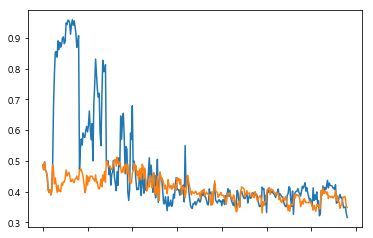

In [244]:
stock_score['현대글로비스']['precision'].plot()
stock_score1['현대글로비스']['precision'].plot()

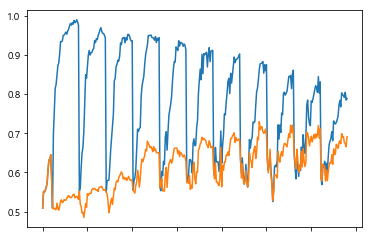

In [246]:
stock_score['삼성전자']['precision'].plot()
stock_score1['삼성전자']['precision'].plot()

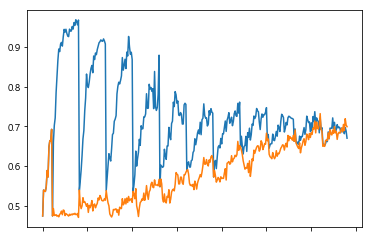

In [247]:
stock_score['KB금융']['precision'].plot()
stock_score1['KB금융']['precision'].plot()

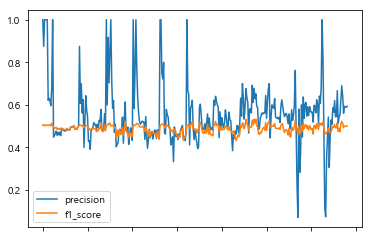

In [264]:
stock_score1['LG생활건강'][['precision', 'f1_score']].plot()

In [368]:
max_precision, max_precision_day = {}, {}
for stock in stock_score1.keys():
    df = stock_score1[stock].iloc[11:]
    df['g_index'] = np.concatenate([i * np.ones(30) for i in range(1,32,3)])
    df = df.groupby('g_index').mean()
    max_precision_day[stock] = df['precision'].idxmax()
    max_precision[stock] = df['precision'].max()

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [292]:
max_precision

{'KB금융': 31.0,
 'LG': 28.0,
 'LG생활건강': 22.0,
 'LG화학': 28.0,
 'NAVER': 16.0,
 'SK': 19.0,
 'SK이노베이션': 31.0,
 'SK텔레콤': 28.0,
 'SK하이닉스': 19.0,
 '삼성생명': 7.0,
 '삼성전자': 28.0,
 '삼성중공업': 16.0,
 '셀트리온': 31.0,
 '신한지주': 22.0,
 '현대건설': 25.0,
 '현대글로비스': 7.0}

In [297]:
'{:.0f}'.format(max_precision['신한지주'])

'22'

In [301]:
new_Train = {}
for stock, d_dict in Train.items():
    new_dict = {}
    for y, df in d_dict.items():
        if y.find('Y1') != -1:
            continue
        elif y[2:4] == '01':
            new_dict[y] = df
        elif y[2:4] == '{:.0f}'.format(max_precision_day[stock]):
            new_dict[y] = df
    new_Train[stock] = new_dict

new_Test = {}
for stock, d_dict in Test.items():
    new_dict = {}
    for y, df in d_dict.items():
        if y.find('Y1') != -1:
            continue
        elif y[2:4] == '01':
            new_dict[y] = df
        elif y[2:4] == '{:.0f}'.format(max_precision_day[stock]):
            new_dict[y] = df
    new_Test[stock] = new_dict

In [363]:
import sys
mod = sys.modules[__name__]

In [375]:
'{:.0f}'.format(.6*100)

'60'

In [367]:
max_precision['KB금융']

31.0

In [382]:
a = []
getattr(mod, 'a').append(1)
a

[1]

In [431]:
import warnings
warnings.filterwarnings("ignore")

In [432]:
cond_result = {}
train_result = {}

for stock, d_dict in new_Train.items():
    start = time.time()
    
    i = int(max_precision_day[stock])
    res_1, res_max = {}, {}
    stat_1, stat_max = {}, {}
    res = {}
    for cond in [1,2]:
        for maxor in [1, 'max']:
            for percent in [.3,.4,.5,.6,.7,.8,.9]:
                setattr(mod, 'Cond{0}_{1}_{2:.0f}'.format(cond, maxor, percent*100), {})
    for y, df in d_dict.items():
        comp_y = 'Y1_{}'.format(y[2:4])

        X_li = [i for i in df.columns if y != i]
        X_train = df[X_li]
        y_train = df[y]
        X_test = new_Test[stock][y][X_li]
        Y_test = Y1_test[stock][comp_y]

        xgb_reg = xgb.XGBRegressor(
             learning_rate =0.15,
             n_estimators=100,
             max_depth=5,
             min_child_weight=2,
             gamma=0,
             subsample=0.8,
             colsample_bytree=0.8,
             nthread=4,
             scale_pos_weight=1,
             seed=27,
             eval_metric='map')

        xgb_reg.fit(X_train, y_train)

        y_true = np.where(Y_test>0, 1, 0)
        y_pred = np.where(xgb_reg.predict(X_test)>0, 1, 0)

        measure = [
            met.accuracy_score(y_true, y_pred),
            met.precision_score(y_true, y_pred),
            met.recall_score(y_true, y_pred),
            met.f1_score(y_true, y_pred),
            met.roc_auc_score(y_true, y_pred)
        ]

        k = 0
        n = 1 if y[2:4] == '01' else int(max_precision_day[stock])
        Y1_dtrain = pd.concat((Y1_train[stock][comp_y], 
                               Y1_test[stock][comp_y]),
                             axis=0)
        X_dtrain = pd.concat((X_train, X_test), axis=0)
        
        cond1_30, cond1_40, cond1_50, cond1_60, cond1_70, cond1_80 = [], [], [], [], [], []
        cond2_50, cond2_60, cond2_70, cond2_80, cond2_90 = [], [], [], [], []
        
        while k < 2278-2005-90-1:
            pred_90 = xgb_reg.predict(X_dtrain.iloc[2006-90-n+k:2006-n+k])
            true_90 = Y1_dtrain.iloc[2006-90-n+k:2006-n+k]
            precision_90 = met.precision_score(
                np.where(true_90>0,1,0), 
                np.where(pred_90>0,1,0))

            for TOL in [.3,.4,.5,.6,.7,.8]:
                if precision_90 < TOL:
                    getattr(mod, 'cond1_{:.0f}'.format(int(TOL*100))).append(-1)
                else:
                    getattr(mod, 'cond1_{:.0f}'.format(int(TOL*100))).append(np.nan)

            for alpha in [.5,.6,.7,.8,.9]:
                if precision_90 < max_precision[stock] * alpha:
                    getattr(mod, 'cond2_{:.0f}'.format(int(alpha*100))).append(-1) 
                else:
                    getattr(mod, 'cond2_{:.0f}'.format(int(alpha*100))).append(np.nan)
            k += 1
        for cond in [cond1_30, cond1_40, cond1_50, cond1_60, cond1_70, cond1_80,
                cond2_50, cond2_60, cond2_70, cond2_80, cond2_90]:
            for i in range(90):
                cond.append(np.nan)

        if y[2:4] == '01':
            res_1['Pred_{}'.format(y[-2:])] = y_pred
            stat_1['Pred_{}'.format(y[-2:])] = measure
            
            Cond1_1_30['Pred_{}'.format(y[-2:])] = cond1_30
            Cond1_1_40['Pred_{}'.format(y[-2:])] = cond1_40
            Cond1_1_50['Pred_{}'.format(y[-2:])] = cond1_50
            Cond1_1_60['Pred_{}'.format(y[-2:])] = cond1_60
            Cond1_1_70['Pred_{}'.format(y[-2:])] = cond1_70
            Cond1_1_80['Pred_{}'.format(y[-2:])] = cond1_80
            Cond2_1_50['Pred_{}'.format(y[-2:])] = cond2_50
            Cond2_1_60['Pred_{}'.format(y[-2:])] = cond2_60
            Cond2_1_70['Pred_{}'.format(y[-2:])] = cond2_70
            Cond2_1_80['Pred_{}'.format(y[-2:])] = cond2_80
            Cond2_1_90['Pred_{}'.format(y[-2:])] = cond2_90
        else:
            res_max['Pred_{}'.format(y[-2:])] = y_pred
            stat_max['Pred_{}'.format(y[-2:])] = measure
            
            Cond1_max_30['Pred_{}'.format(y[-2:])] = cond1_30
            Cond1_max_40['Pred_{}'.format(y[-2:])] = cond1_40
            Cond1_max_50['Pred_{}'.format(y[-2:])] = cond1_50
            Cond1_max_60['Pred_{}'.format(y[-2:])] = cond1_60
            Cond1_max_70['Pred_{}'.format(y[-2:])] = cond1_70
            Cond1_max_80['Pred_{}'.format(y[-2:])] = cond1_80
            Cond2_max_50['Pred_{}'.format(y[-2:])] = cond2_50
            Cond2_max_60['Pred_{}'.format(y[-2:])] = cond2_60
            Cond2_max_70['Pred_{}'.format(y[-2:])] = cond2_70
            Cond2_max_80['Pred_{}'.format(y[-2:])] = cond2_80
            Cond2_max_90['Pred_{}'.format(y[-2:])] = cond2_90

    for cond in [1,2]:
        for maxor in [1, 'max']:
            for percent in [.3,.4,.5,.6,.7,.8,.9]:
                try:
                    c = getattr(mod, 'Cond{0}_{1}_{2:.0f}'.format(cond, maxor, percent*100))
                except:
                    continue
                res['Cond{0}_{1}_{2:.0f}'.format(cond, maxor, percent*100)] = pd.DataFrame(c)
    cond_result[stock] = res
    train_result[stock] = (res_1, stat_1, res_max, stat_max)
    print(stock, ': {:.2f} sec'.format(time.time() - start))

KB금융 : 33.21 sec
LG : 35.12 sec
LG생활건강 : 34.90 sec
LG화학 : 35.20 sec
NAVER : 34.61 sec
SK : 31.79 sec
SK이노베이션 : 35.57 sec
SK텔레콤 : 43.87 sec
SK하이닉스 : 35.68 sec
삼성생명 : 14.90 sec
삼성전자 : 37.24 sec
삼성중공업 : 37.27 sec
셀트리온 : 36.25 sec
신한지주 : 36.30 sec
현대건설 : 37.91 sec
현대글로비스 : 17.45 sec


In [446]:
pd.DataFrame(train_result['KB금융'][2])

Pred_01  Pred_04  Pred_07  Pred_10  Pred_13  Pred_16  Pred_19  Pred_22  \
0          0        1        1        1        1        1        1        1   
1          0        1        1        1        1        1        1        1   
2          0        1        1        1        1        1        1        1   
3          1        1        1        1        1        1        1        1   
4          0        1        0        1        1        1        0        1   
5          1        1        1        1        1        1        0        1   
6          1        1        1        0        0        0        0        0   
7          0        0        0        0        0        1        0        0   
8          0        1        0        0        0        0        0        0   
9          0        0        0        0        0        0        0        0   
10         0        1        0        0        0        0        0        0   
11         0        0        0        0        0        0        0        0   
12         0        0        0        0        0        0        0        0   
13         0        0        0        0        0        0        0        0   
14         0        0        0        0        0        0        0        0   
15         0        0        0        0        0        0        0        0   
16         0        0        0        0        0        0        0        0   
17         0        0        0        0        0        0        0        0   
18         0        0        0        0        0        0        0        0   
19         0        0        0        0        0        0        0        0   
20         0        0        0        0        0        0        0        0   
21         0        0        0        0        0        0        0        0   
22         0        0        0        0        0        0        0        0   
23         0        0        0        0        0        0        0        0   
24         0        0        0        0        0        0        0        0   
25         0        0        0        0        0        0        0        0   
26         0        0        0        0        0        0        0        0   
27         0        0        0        0        0        0        0        0   
28         0        0        0        0        0        0        0        0   
29         0        0        0        0        0        0        0        0   
..       ...      ...      ...      ...      ...      ...      ...      ...   
242        0        0        0        0        0        0        0        0   
243        0        0        0        0        0        0        0        0   
244        0        0        0        0        0        0        0        0   
245        0        0        0        0        0        0        0        0   
246        0        0        0        0        0        0        0        0   
247        0        0        0        0        0        0        0        0   
248        0        0        0        0        0        0        0        0   
249        0        0        0        0        0        0        0        0   
250        0        0        0        0        0        0        0        0   
251        0        0        0        0        0        0        0        0   
252        0        0        0        0        0        0        0        0   
253        0        0        0        0        0        0        0        0   
254        0        0        0        0        0        0        0        0   
255        0        0        0        0        0        0        0        0   
256        0        0        0        0        0        0        0        0   
257        0        0        0        0        0        0        0        0   
258        0        0        0        0        0        0        0        0   
259        0        0        0        0        0        0        0        0   
260        0        0        0        0        0       

In [447]:
base_result = {}
for stock, d_dict in train_result.items():
    base_result[stock] = pd.DataFrame(d_dict[2])

In [453]:
adjust_cond = {}
for stock, cond_dict in cond_result.items():
    r = {}
    for cond, df in cond_dict.items():
        for cond2, df2 in cond_dict.items():
            if cond==cond2:
                name = cond
            else:
                name = cond+'+'+cond2
            r[name] = df.fillna(df2)
    adjust_cond[stock] = r                    

In [454]:
len(adjust_cond['KB금융'].keys())

784

In [574]:
adjust_cond['KB금융']['Cond1_1_30']

Pred_01  Pred_04  Pred_07  Pred_10  Pred_13  Pred_16  Pred_19  Pred_22  \
0        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
3        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
4        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
5        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
7        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
8        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
9        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
10       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
11       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
12       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
13       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
15       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
16       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
17       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
18       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
19       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
20       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
21       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
22       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
23       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
24       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
25       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
26       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
27       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
28       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
29       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
..       ...      ...      ...      ...      ...      ...      ...      ...   
242      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
243      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
244      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
245      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
246      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
247      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
248      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
249      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
250      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
251      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
252      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
253      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
254      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
255      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
256      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
257      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
258      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
259      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
260      NaN      NaN      NaN      NaN      NaN      N

In [575]:
adjust_cond['KB금융']['Cond1_1_90']

Empty DataFrame
Columns: []
Index: []

In [573]:
adjust_cond['KB금융']['Cond1_1_30+Cond1_1_90']

Pred_01  Pred_04  Pred_07  Pred_10  Pred_13  Pred_16  Pred_19  Pred_22  \
0        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
3        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
4        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
5        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
7        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
8        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
9        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
10       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
11       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
12       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
13       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
15       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
16       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
17       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
18       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
19       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
20       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
21       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
22       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
23       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
24       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
25       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
26       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
27       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
28       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
29       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
..       ...      ...      ...      ...      ...      ...      ...      ...   
242      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
243      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
244      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
245      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
246      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
247      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
248      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
249      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
250      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
251      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
252      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
253      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
254      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
255      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
256      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
257      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
258      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
259      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
260      NaN      NaN      NaN      NaN      NaN      N

In [455]:
adjust_cond['KB금융'].keys()

dict_keys(['Cond1_1_30', 'Cond1_1_30+Cond1_1_40', 'Cond1_1_30+Cond1_1_50', 'Cond1_1_30+Cond1_1_60', 'Cond1_1_30+Cond1_1_70', 'Cond1_1_30+Cond1_1_80', 'Cond1_1_30+Cond1_1_90', 'Cond1_1_30+Cond1_max_30', 'Cond1_1_30+Cond1_max_40', 'Cond1_1_30+Cond1_max_50', 'Cond1_1_30+Cond1_max_60', 'Cond1_1_30+Cond1_max_70', 'Cond1_1_30+Cond1_max_80', 'Cond1_1_30+Cond1_max_90', 'Cond1_1_30+Cond2_1_30', 'Cond1_1_30+Cond2_1_40', 'Cond1_1_30+Cond2_1_50', 'Cond1_1_30+Cond2_1_60', 'Cond1_1_30+Cond2_1_70', 'Cond1_1_30+Cond2_1_80', 'Cond1_1_30+Cond2_1_90', 'Cond1_1_30+Cond2_max_30', 'Cond1_1_30+Cond2_max_40', 'Cond1_1_30+Cond2_max_50', 'Cond1_1_30+Cond2_max_60', 'Cond1_1_30+Cond2_max_70', 'Cond1_1_30+Cond2_max_80', 'Cond1_1_30+Cond2_max_90', 'Cond1_1_40+Cond1_1_30', 'Cond1_1_40', 'Cond1_1_40+Cond1_1_50', 'Cond1_1_40+Cond1_1_60', 'Cond1_1_40+Cond1_1_70', 'Cond1_1_40+Cond1_1_80', 'Cond1_1_40+Cond1_1_90', 'Cond1_1_40+Cond1_max_30', 'Cond1_1_40+Cond1_max_40', 'Cond1_1_40+Cond1_max_50', 'Cond1_1_40+Cond1_max_60', 

In [457]:
adj_result = {}
for stock, d_dict in adjust_cond.items():
    r = {}
    for cond_name, df in d_dict.items():
        r[cond_name] = df.fillna(base_result[stock])
    adj_result[stock] = r

In [458]:
len(adj_result['KB금융'].keys())

784

In [487]:
def step_fn(x):
    if x > .5: return 1
    else: return 0
    
for stock, d_dict in adj_result.items():
    for cond_name, df in d_dict.items():
        adj_result[stock][cond_name] = \
            df.replace(-1, np.nan).mean(1).map(step_fn)

In [521]:
close = raw_data[stock]['Close'].loc['2017-06-30':]

In [582]:
np.mean(close.iloc[15:20])

153900.0

In [553]:
close.iloc[20]

162000.0

In [647]:
max_precision_day

{'KB금융': 31.0,
 'LG': 28.0,
 'LG생활건강': 22.0,
 'LG화학': 28.0,
 'NAVER': 16.0,
 'SK': 19.0,
 'SK이노베이션': 31.0,
 'SK텔레콤': 28.0,
 'SK하이닉스': 19.0,
 '삼성생명': 7.0,
 '삼성전자': 28.0,
 '삼성중공업': 16.0,
 '셀트리온': 31.0,
 '신한지주': 22.0,
 '현대건설': 25.0,
 '현대글로비스': 7.0}

In [ ]:
pred = adj_result['삼성전자']['Cond1_1_30']
pred.iloc[]

In [685]:
raw_data['삼성전자']['Close'].loc['2017-06-30':]

Date
2017-06-30    47540.0
2017-07-03    47220.0
2017-07-04    47000.0
2017-07-05    47580.0
2017-07-06    48060.0
2017-07-07    47860.0
2017-07-10    48660.0
2017-07-11    49000.0
2017-07-12    49880.0
2017-07-13    50560.0
2017-07-14    50480.0
2017-07-17    50640.0
2017-07-18    50840.0
2017-07-19    50740.0
2017-07-20    51200.0
2017-07-21    51080.0
2017-07-24    50860.0
2017-07-25    50000.0
2017-07-26    49840.0
2017-07-27    49800.0
2017-07-28    47760.0
2017-07-31    48200.0
2017-08-01    48600.0
2017-08-02    49000.0
2017-08-03    47780.0
2017-08-04    47700.0
2017-08-07    47580.0
2017-08-08    47720.0
2017-08-09    46280.0
2017-08-10    45900.0
               ...   
2018-07-03    46150.0
2018-07-04    46250.0
2018-07-05    45950.0
2018-07-06    44900.0
2018-07-09    45600.0
2018-07-10    46300.0
2018-07-11    46000.0
2018-07-12    45500.0
2018-07-13    46500.0
2018-07-16    46050.0
2018-07-17    45850.0
2018-07-18    46550.0
2018-07-19    46900.0
2018-07-20    47450.0
2018-

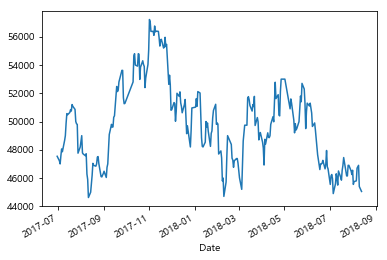

In [652]:
close.plot()

In [649]:
def transaction(stock, pred, n, 
                judge_period=1, hold_period=5):
    res = pd.Series(index=range(272))
    close = raw_data[stock]['Close'].loc['2017-06-30':]
    number, stamp = 0, 0
    for idx in range(270):
        if judge_period > 1:
            buy_condition = \
            (np.mean(pred.iloc[idx-judge_period+1:idx+1]) >= .5)
        else:
            buy_condition = (pred.iloc[idx] == 1)
        if idx < n: continue
        if (buy_condition) | (stamp > 0):
            res.iloc[idx+2] = np.log(
                close.iloc[idx+2] / close.iloc[idx+1])
            if stamp == 0:
                stamp = hold_period
                number += 1
            else:
                stamp -= 1
    return res, number

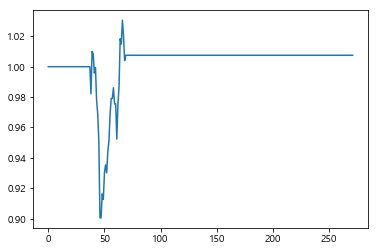

In [558]:
(trans1('KB금융', adj_result['KB금융']['Cond2_max_70'], 31)[0].fillna(0)+1).cumprod().plot()

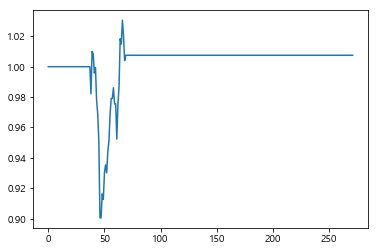

In [560]:
(transaction('KB금융', adj_result['KB금융']['Cond2_max_70'], 31, 1, 31)[0].fillna(0)+1).cumprod().plot()

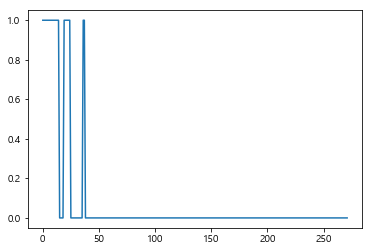

In [544]:
adj_result['KB금융']['Cond2_max_70'].plot()

In [568]:
stock

'KB금융'

In [569]:
cond_name

'Cond1_1_90+Cond1_1_30'

In [585]:
# trans1
stock_returns1 = {}
print('Transaction 1')
for stock, d_dict in adj_result.items():
    start = time.time()
    mid_check = {}
    for cond_name, pred in d_dict.items():
        n = int(max_precision_day[stock])
        try:
            res, number = transaction(stock, pred, n, 5, 5)
        except IndexError:
            continue
        res = (res.fillna(0)+1).cumprod()
        mid_check[cond_name] = (res.iloc[-1], res, number)
    stock_returns1[stock] = mid_check
    print(stock, ': {:.2f} sec'.format(time.time() - start))

# trans2
stock_returns2 = {}
print('\nTransaction 2')
for stock, d_dict in adj_result.items():
    start = time.time()
    mid_check = {}
    for cond_name, pred in d_dict.items():
        n = int(max_precision_day[stock])
        try:
            res, number = transaction(stock, pred, n, 1, 5)
        except IndexError:
            continue
        res = (res.fillna(0)+1).cumprod()
        mid_check[cond_name] = (res.iloc[-1], res, number)
    stock_returns2[stock] = mid_check
    print(stock, ': {:.2f} sec'.format(time.time() - start))

# trans3
stock_returns3 = {}
print('\nTransaction 3')
for stock, d_dict in adj_result.items():
    start = time.time()
    mid_check = {}
    for cond_name, pred in d_dict.items():
        n = int(max_precision_day[stock])
        try:
            res, number = transaction(stock, pred, n, n, n)
        except IndexError:
            continue
        res = (res.fillna(0)+1).cumprod()
        mid_check[cond_name] = (res.iloc[-1], res, number)
    stock_returns3[stock] = mid_check
    print(stock, ': {:.2f} sec'.format(time.time() - start))
    
# trans4
stock_returns4 = {}
print('\nTransaction 4')
for stock, d_dict in adj_result.items():
    start = time.time()
    mid_check = {}
    for cond_name, pred in d_dict.items():
        n = int(max_precision_day[stock])
        try:
            res, number = transaction(stock, pred, n, 1, n)
        except IndexError:
            continue
        res = (res.fillna(0)+1).cumprod()
        mid_check[cond_name] = (res.iloc[-1], res, number)
    stock_returns4[stock] = mid_check
    print(stock, ': {:.2f} sec'.format(time.time() - start))

Transaction 1
KB금융 : 28.51 sec
LG : 33.77 sec
LG생활건강 : 32.91 sec
LG화학 : 45.62 sec
NAVER : 48.81 sec
SK : 28.76 sec
SK이노베이션 : 31.53 sec
SK텔레콤 : 35.37 sec
SK하이닉스 : 44.20 sec
삼성생명 : 25.74 sec
삼성전자 : 51.86 sec
삼성중공업 : 40.72 sec
셀트리온 : 43.36 sec
신한지주 : 36.66 sec
현대건설 : 41.88 sec
현대글로비스 : 25.73 sec

Transaction 2
KB금융 : 4.69 sec
LG : 8.72 sec
LG생활건강 : 6.16 sec
LG화학 : 16.21 sec
NAVER : 15.97 sec
SK : 3.91 sec
SK이노베이션 : 6.42 sec
SK텔레콤 : 9.67 sec
SK하이닉스 : 15.47 sec
삼성생명 : 2.31 sec
삼성전자 : 22.24 sec
삼성중공업 : 14.18 sec
셀트리온 : 12.32 sec
신한지주 : 11.71 sec
현대건설 : 16.03 sec
현대글로비스 : 2.94 sec

Transaction 3
KB금융 : 34.80 sec
LG : 33.51 sec
LG생활건강 : 30.70 sec
LG화학 : 45.20 sec
NAVER : 43.50 sec
SK : 27.85 sec
SK이노베이션 : 33.39 sec
SK텔레콤 : 34.00 sec
SK하이닉스 : 51.03 sec
삼성생명 : 25.60 sec
삼성전자 : 48.52 sec
삼성중공업 : 41.59 sec
셀트리온 : 38.29 sec
신한지주 : 38.23 sec
현대건설 : 46.10 sec
현대글로비스 : 25.90 sec

Transaction 4
KB금융 : 5.80 sec
LG : 10.27 sec
LG생활건강 : 6.81 sec
LG화학 : 20.58 sec
NAVER : 18.54 sec
SK : 3.91 sec
SK이노베이션 : 1

In [586]:
return_close = {}
return_close['trans1'] = stock_returns1
return_close['trans2'] = stock_returns2
return_close['trans3'] = stock_returns3
return_close['trans4'] = stock_returns4

In [670]:
pd.Series({i:j[0] for i,j in return_close['trans2']['삼성중공업'].items()}).plot()

TypeError: Empty 'DataFrame': no numeric data to plot

In [631]:
stock = '삼성전자'
mid_check = {}
for cond_name, pred in d_dict.items():
    n = int(max_precision_day[stock])
    try:
        res, number = transaction(stock, pred, n, 1, 5)
    except IndexError:
        continue
    res = (res.fillna(0)+1).cumprod()
    mid_check[cond_name] = (res.iloc[-1], res, number)

In [635]:
mid_check

{'Cond1_1_30': (1.0, 0      1.0
  1      1.0
  2      1.0
  3      1.0
  4      1.0
  5      1.0
  6      1.0
  7      1.0
  8      1.0
  9      1.0
  10     1.0
  11     1.0
  12     1.0
  13     1.0
  14     1.0
  15     1.0
  16     1.0
  17     1.0
  18     1.0
  19     1.0
  20     1.0
  21     1.0
  22     1.0
  23     1.0
  24     1.0
  25     1.0
  26     1.0
  27     1.0
  28     1.0
  29     1.0
        ... 
  242    1.0
  243    1.0
  244    1.0
  245    1.0
  246    1.0
  247    1.0
  248    1.0
  249    1.0
  250    1.0
  251    1.0
  252    1.0
  253    1.0
  254    1.0
  255    1.0
  256    1.0
  257    1.0
  258    1.0
  259    1.0
  260    1.0
  261    1.0
  262    1.0
  263    1.0
  264    1.0
  265    1.0
  266    1.0
  267    1.0
  268    1.0
  269    1.0
  270    1.0
  271    1.0
  Length: 272, dtype: float64, 0), 'Cond1_1_30+Cond1_1_40': (1.0, 0      1.0
  1      1.0
  2      1.0
  3      1.0
  4      1.0
  5      1.0
  6      1.0
  7      1.0
  8      1.0
  9    

In [ ]:
def transaction(stock, pred, term1):
    tran_table = pd.DataFrame(columns = ['profit'])
    now_index = 0
    tran_table.loc['2017-06-30'] = 0
    while now_index <= len(pred):
        if pred.iloc[now_index] > 0:
            tran_table.loc[pred.index[now_index+term1]] = \
                np.log(
                    raw_data[stock]['Close'].loc[
                        pred.index[
                            now_index+term1
                        ]]/raw_data[stock]['Close'].loc[pred.index[now_index]])
            now_index = now_index + term1
        else:
            now_index = now_index + 1

        if now_index + term1 >= len(pred):
            break

    tran_table = tran_table+1
    tran_table = tran_table.cumprod()
    
    return tran_table

In [357]:
a = pd.DataFrame([[1,2,3],[4,5,6],[7,8,9]])
b = pd.DataFrame([[np.nan,-1,np.nan],[np.nan,-1,np.nan],[np.nan,np.nan,-1]])

In [358]:
a

0  1  2
0  1  2  3
1  4  5  6
2  7  8  9

In [359]:
b

0    1    2
0 NaN -1.0  NaN
1 NaN -1.0  NaN
2 NaN  NaN -1.0

In [360]:
b.fillna(a)

0    1    2
0  1.0 -1.0  3.0
1  4.0 -1.0  6.0
2  7.0  8.0 -1.0

In [356]:
Y_test

Date
2017-06-30   -0.015721
2017-07-03   -0.008688
2017-07-04   -0.013938
2017-07-05   -0.014060
2017-07-06   -0.033249
2017-07-07   -0.010638
2017-07-10   -0.014035
2017-07-11   -0.024868
2017-07-12    0.000000
2017-07-13    0.008795
2017-07-14   -0.015831
2017-07-17   -0.014035
2017-07-18   -0.035465
2017-07-19   -0.030496
2017-07-20   -0.062914
2017-07-21   -0.157221
2017-07-24   -0.163888
2017-07-25   -0.136412
2017-07-26   -0.148620
2017-07-27   -0.122821
2017-07-28   -0.098558
2017-07-31   -0.117783
2017-08-01   -0.109457
2017-08-02   -0.074901
2017-08-03   -0.040967
2017-08-04   -0.037074
2017-08-07   -0.059354
2017-08-08   -0.047088
2017-08-09   -0.045863
2017-08-10   -0.045863
                ...   
2018-07-03   -0.035229
2018-07-04   -0.013579
2018-07-05   -0.028876
2018-07-06   -0.054990
2018-07-09   -0.081100
2018-07-10   -0.070304
2018-07-11   -0.041752
2018-07-12   -0.001892
2018-07-13   -0.048157
2018-07-16   -0.022515
2018-07-17   -0.074941
2018-07-18   -0.065505
2018-0

In [355]:
k = 0
while k < 2278-2005-90:
    k+=1
k+2006-1, k

(2188, 183)

In [341]:
X_dtrain = pd.concat((X_train, X_test), axis=0)

In [348]:
    Y1_dtrain = pd.concat((Y1_train[stock][comp_y], 
                           Y1_test[stock][comp_y]),
                         axis=0)

In [352]:
X_dtrain

sto_K_88   sto_D_88     RSI_75   close_ma_90  close_ema_90  \
Date                                                                      
2009-06-02  75.892842  70.907728  55.263160  35545.935395  37796.867395   
2009-06-03  72.990839  74.404731  55.762642  35642.686502  37878.277815   
2009-06-04  63.839503  70.907728  55.449432  35734.003190  37912.969532   
2009-06-05  68.080253  68.303532  57.256626  35797.598763  37967.654288   
2009-06-08  63.169666  65.029808  56.676030  35834.016558  37997.039976   
2009-06-09  58.035498  63.095139  56.548583  35855.214345  38000.616419   
2009-06-10  69.196345  63.467170  57.221901  35924.244380  38058.745508   
2009-06-11  73.660676  66.964173  58.523025  35994.905491  38137.401570   
2009-06-12  72.767721  71.874914  58.161526  36065.566602  38209.906453   
2009-06-15  71.428510  72.618969  57.897623  36152.534397  38274.220031   
2009-06-16  70.535555  71.577262  57.005608  36220.477756  38332.712492   
2009-06-17  63.839503  68.601190  56.877124  36269.941124  38357.159556   
2009-06-18  59.598290  64.657783  56.305782  36307.446680  38360.334684   
2009-06-19  62.499830  61.979208  56.208021  36366.693338  38377.608238   
2009-06-22  73.437558  65.178559  57.943878  36472.685569  38447.891691   
2009-06-23  66.517924  67.485104  57.658646  36552.044466  38482.816099   
2009-06-24  69.643045  69.866176  58.011951  36654.775586  38532.201152   
2009-06-25  74.776768  70.312579  57.079347  36786.857834  38605.514724   
2009-06-26  74.776768  73.065527  56.004530  36941.768967  38677.176509   
2009-06-29  72.544584  74.032707  55.813939  37093.418946  38736.342240   
2009-06-30  74.999886  74.107079  56.246447  37261.375608  38806.143297   
2009-07-01  91.518038  79.687503  57.658645  37457.597852  38954.861159   
2009-07-02  89.955245  85.491056  56.393019  37664.146767  39092.622437   
2009-07-03  89.955245  90.476176  56.901344  37865.260113  39227.287986   
2009-07-06  85.714478  88.541656  57.451625  38054.415669  39338.280604   
2009-07-07  82.366220  86.011981  57.029938  38218.024544  39430.482702   
2009-07-08  81.250146  83.110282  56.452508  38393.047895  39515.184242   
2009-07-09  87.946198  83.854188  56.103116  38584.920117  39630.566164   
2009-07-10  93.526621  87.574322  56.649638  38781.141233  39770.507249   
2009-07-13  83.258730  88.243850  54.458719  38962.142340  39857.375120   
...               ...        ...        ...           ...           ...   
2018-07-03   6.896552   6.090007  40.659341  58722.222222  57592.003127   
2018-07-04   6.250000   5.980357  41.035120  58557.777778  57466.904158   
2018-07-05  12.056738   8.401096  41.788321  58415.555556  57362.137033   
2018-07-06  22.695035  13.667258  42.314647  58296.666667  57292.639516   
2018-07-09  30.434783  21.728852  43.137255  58191.111111  57246.647439   
2018-07-10  25.362319  26.164046  41.889483  58084.444444  57186.281561   
2018-07-11  20.895522  25.564208  41.814947  57971.111111  57111.857790   
2018-07-12  14.179104  20.145649  40.213523  57847.777778  57019.289487   
2018-07-13  32.089552  22.388060  44.404973  57756.666667  56981.502905   
2018-07-16  21.641791  22.636816  43.936731  57664.444444  56913.777567   
2018-07-17  32.835821  28.855721  44.905009  57587.777778  56880.507730   
2018-07-18  31.343284  28.606965  45.694200  57517.777778  56843.573494   
2018-07-19  19.402985  27.860697  42.982456  57426.666667  56772.286165   
2018-07-20  21.641791  24.129353  43.971631  57331.111111  56709.158996   
2018-07-23  21.641791  20.895522  44.927536  57218.888889  56647.419238   
2018-07-24  17.910448  20.398010  45.925926  57121.111111  56576.047387   
2018-07-25  25.373134  21.641791  47.080292  57041.111111  56528.222169   
2018-07-26  18.656716  20.646766  45.833333  56950.000000  56461.667836   
2018-07-27  19.402985  21.144279  45.735027  56848.888889  56398.774037   
2018-07-30  21.641791  19.900498  47.486034  56748.888889  56343.855927   
2018-07-31  22.807018  21.283931  45.1

In [331]:
pd.DataFrame(res_max)

Pred_01  Pred_04  Pred_07  Pred_10  Pred_13  Pred_16  Pred_19  Pred_22  \
0          0        1        1        1        1        1        1        1   
1          0        1        1        1        1        1        1        1   
2          0        1        1        1        1        1        1        1   
3          1        1        1        1        1        1        1        1   
4          0        1        0        1        1        1        0        1   
5          1        1        1        1        1        1        0        1   
6          1        1        1        0        0        0        0        0   
7          0        0        0        0        0        1        0        0   
8          0        1        0        0        0        0        0        0   
9          0        0        0        0        0        0        0        0   
10         0        1        0        0        0        0        0        0   
11         0        0        0        0        0        0        0        0   
12         0        0        0        0        0        0        0        0   
13         0        0        0        0        0        0        0        0   
14         0        0        0        0        0        0        0        0   
15         0        0        0        0        0        0        0        0   
16         0        0        0        0        0        0        0        0   
17         0        0        0        0        0        0        0        0   
18         0        0        0        0        0        0        0        0   
19         0        0        0        0        0        0        0        0   
20         0        0        0        0        0        0        0        0   
21         0        0        0        0        0        0        0        0   
22         0        0        0        0        0        0        0        0   
23         0        0        0        0        0        0        0        0   
24         0        0        0        0        0        0        0        0   
25         0        0        0        0        0        0        0        0   
26         0        0        0        0        0        0        0        0   
27         0        0        0        0        0        0        0        0   
28         0        0        0        0        0        0        0        0   
29         0        0        0        0        0        0        0        0   
..       ...      ...      ...      ...      ...      ...      ...      ...   
242        0        0        0        0        0        0        0        0   
243        0        0        0        0        0        0        0        0   
244        0        0        0        0        0        0        0        0   
245        0        0        0        0        0        0        0        0   
246        0        0        0        0        0        0        0        0   
247        0        0        0        0        0        0        0        0   
248        0        0        0        0        0        0        0        0   
249        0        0        0        0        0        0        0        0   
250        0        0        0        0        0        0        0        0   
251        0        0        0        0        0        0        0        0   
252        0        0        0        0        0        0        0        0   
253        0        0        0        0        0        0        0        0   
254        0        0        0        0        0        0        0        0   
255        0        0        0        0        0        0        0        0   
256        0        0        0        0        0        0        0        0   
257        0        0        0        0        0        0        0        0   
258        0        0        0        0        0        0        0        0   
259        0        0        0        0        0        0        0        0   
260        0        0        0        0        0       

In [304]:
i

31

In [ ]:
stock_score = {}
for stock, d_dict in Train.items():
    print(stock)
    start = time.time()
    res = {}
    for y, df in d_dict.items():
        if len(y) > 6:
            comp_y = 'Y1_{}'.format(y[2:4])
        else:
            comp_y = y
        X_li = [i for i in df.columns if y != i]
        X_train = df.iloc[:int(.7*len(df))][X_li]
        y_train = df.iloc[:int(.7*len(df))][y]
        X_test = df.iloc[int(.7*len(df)):][X_li]
        Y_test = df.iloc[int(.7*len(df)):][y]
#         Y_test = Y1_train[stock].iloc[int(.7*len(df)):][comp_y]
        
        xgb_reg = xgb.XGBRegressor(
             learning_rate =0.15,
             n_estimators=100,
             max_depth=5,
             min_child_weight=2,
             gamma=0,
             subsample=0.8,
             colsample_bytree=0.8,
             nthread=4,
             scale_pos_weight=1,
             seed=27,
             eval_metric='map')
#         xgb_reg = optimize_n_estimators(alg, X_train, y_train)
        xgb_reg.fit(X_train, y_train)
        # 여기에 최적화 작업 들어가도 괜찮
        
        y_true = np.where(Y_test>0, 1, 0)
        y_pred = np.where(xgb_reg.predict(X_test)>0, 1, 0)
        
        measure = [
            met.accuracy_score(y_true, y_pred),
            met.precision_score(y_true, y_pred),
            met.recall_score(y_true, y_pred),
            met.f1_score(y_true, y_pred),
            met.roc_auc_score(y_true, y_pred)
        ]
        res[y] = measure
    elapse = time.time() - start
    print('{:.2f} sec'.format(elapse))
    T = pd.DataFrame(res).T
    T.columns = ['accuracy',
                'precision',
                'recall',
                'auc',
                'f1_score']
    stock_score[stock] = T

In [160]:
with open('raw_and_prepare_columns_20190416.pickle', 'rb') as handle:
    a,b = pickle.load(handle)

In [163]:
store = (Train, Test, b)
with open('dataset_20190416.pickle', 'wb') as handle:
    pickle.dump(store, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [218]:
a

1         2         3         4         6
Y1_01       0.545455  0.489712  0.340000  0.401349  0.526148
Y1_04       0.562100  0.527076  0.408964  0.460568  0.550001
Y1_07       0.512164  0.490798  0.645161  0.557491  0.518180
Y1_10       0.504481  0.467257  0.754286  0.577049  0.527955
Y1_13       0.481434  0.445633  0.726744  0.552486  0.507537
Y1_16       0.492958  0.430255  0.673846  0.525180  0.518941
Y1_19       0.423816  0.381944  0.700637  0.494382  0.469162
Y1_22       0.428937  0.395385  0.829032  0.535417  0.497319
Y1_25       0.426376  0.398592  0.930921  0.558185  0.517871
Y1_28       0.445583  0.391872  0.950704  0.554985  0.553823
Y1_31       0.443022  0.398876  0.975945  0.566301  0.551238
sh01_Y2_01  0.545455  0.489712  0.340000  0.401349  0.526148
sh01_Y2_04  0.517286  0.445344  0.314286  0.368509  0.498210
sh01_Y2_07  0.487836  0.419872  0.374286  0.395770  0.477166
sh01_Y2_10  0.503201  0.434028  0.357143  0.391850  0.489476
sh01_Y2_13  0.508323  0.428571  0.291429  0.346939  0.487942
sh01_Y2_16  0.491677  0.404082  0.282857  0.332773  0.472055
sh01_Y2_19  0.490397  0.412409  0.322857  0.362179  0.474654
sh01_Y2_22  0.486556  0.401544  0.297143  0.341544  0.468757
sh01_Y2_25  0.487836  0.406716  0.311429  0.352751  0.471260
sh01_Y2_28  0.491677  0.409266  0.302857  0.348112  0.473934
sh01_Y2_31  0.487836  0.405303  0.305714  0.348534  0.470723
sh01_Y2_34  0.501921  0.424710  0.314286  0.361248  0.484289
sh01_Y2_37  0.512164  0.438735  0.317143  0.368159  0.493838
sh01_Y2_40  0.516005  0.441176  0.300000  0.357143  0.495708
sh01_Y2_43  0.519846  0.449799  0.320000  0.373957  0.501067
sh01_Y2_46  0.527529  0.465201  0.362857  0.407705  0.512055
sh01_Y2_49  0.530090  0.468401  0.360000  0.407108  0.514107
sh01_Y2_52  0.519846  0.452830  0.342857  0.390244  0.503215
sh01_Y2_55  0.524968  0.460674  0.351429  0.398703  0.508661
...              ...       ...       ...       ...       ...
sh31_Y2_01  0.443022  0.398876  0.975945  0.566301  0.551238
sh31_Y2_04  0.457106  0.403202  0.951890  0.566462  0.557578
sh31_Y2_07  0.472471  0.410635  0.955326  0.574380  0.570520
sh31_Y2_10  0.457106  0.404317  0.965636  0.569980  0.560369
sh31_Y2_13  0.486556  0.414330  0.914089  0.570204  0.573371
sh31_Y2_16  0.494238  0.415033  0.872852  0.562569  0.571120
sh31_Y2_19  0.460948  0.401216  0.907216  0.556375  0.551567
sh31_Y2_22  0.450704  0.396084  0.903780  0.550785  0.542706
sh31_Y2_25  0.472471  0.404724  0.883162  0.555076  0.555866
sh31_Y2_28  0.414853  0.380747  0.910653  0.536981  0.515531
sh31_Y2_31  0.457106  0.390805  0.817869  0.528889  0.530363
sh31_Y2_34  0.409731  0.377522  0.900344  0.531980  0.509355
sh31_Y2_37  0.437900  0.390533  0.907216  0.546019  0.533200
sh31_Y2_40  0.422535  0.383721  0.907216  0.539326  0.520955
sh31_Y2_43  0.416133  0.378498  0.883162  0.529897  0.510969
sh31_Y2_46  0.409731  0.358333  0.738832  0.482604  0.476559
sh31_Y2_49  0.427657  0.370861  0.769759  0.500559  0.497125
sh31_Y2_52  0.394366  0.358255  0.790378  0.493033  0.474781
sh31_Y2_55  0.444302  0.382979  0.804124  0.518847  0.517368
sh31_Y2_58  0.407170  0.361290  0.769759  0.491767  0.480798
sh31_Y2_61  0.387964  0.349920  0.749141  0.477024  0.461305
sh31_Y2_64  0.403329  0.353434  0.725086  0.475225  0.468665
sh31_Y2_67  0.385403  0.345336  0.725086  0.467849  0.454380
sh31_Y2_70  0.396927  0.351485  0.731959  0.474916  0.464959
sh31_Y2_73  0.400768  0.373027  0.893471  0.526316  0.500817
sh31_Y2_76  0.398207  0.347009  0.697595  0.463470  0.459001
sh31_Y2_79  0.403329  0.356792  0.749141  0.483370  0.473550
sh31_Y2_82  0.393086  0.351702  0.745704  0.477974  0.464689
sh31_Y2_85  0.368758  0.329392  0.670103  0.441676  0.429950
sh31_Y2_88  0.371319  0.344720  0.762887  0.474866  0.450831

[341 rows x 5 columns]